## Vehicle detection and tracking

## Extracting the car/not car image filenames 

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import warnings
warnings.filterwarnings('ignore')

### Reading images of vehicles 

In [2]:
images = glob.glob('vehicles/*/*.png')

cars = []

for image in images:
    cars.append(image)

### Reading images of non-vehicles 

In [3]:
images = glob.glob('non-vehicles/*/*.png')

notcars = []

for image in images:
    notcars.append(image)

## Showing some characteristcs of the dataset

In [4]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [5]:
data_info = data_look(cars, notcars)


In [6]:
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


The dataset is not balanced, later we will fix it. 

### Showing images of vehicles and non-vehicles 

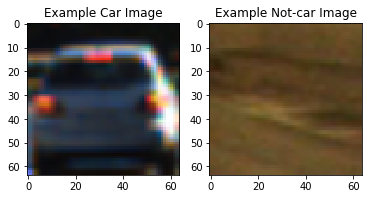

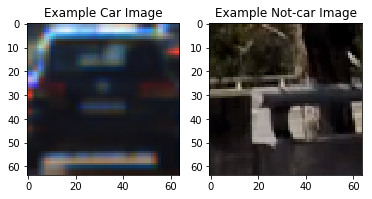

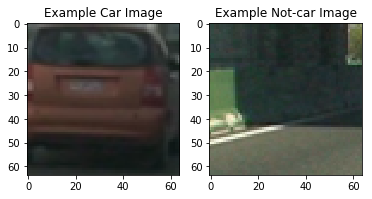

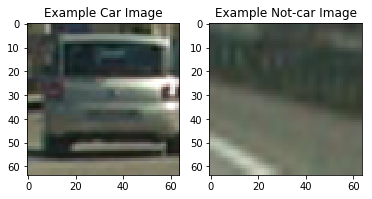

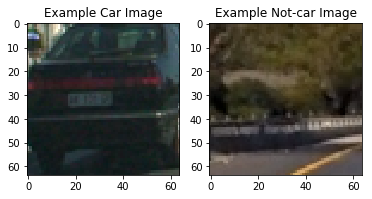

In [7]:
# We are going to choose random car / not-car indices and plot their corresponding images

num_images = 5 


fig = plt.figure()

for i in range(num_images):
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))
    
    # Read in car / not-car images
    car_image = cv2.imread(cars[car_ind],1)
    notcar_image = cv2.imread(notcars[notcar_ind], 1)
    
    # Plot few random images 
    # This web site was useful https://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB))        
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB))        
    plt.title('Example Not-car Image')
    plt.show()
    

### Extracting the HOG features

In order to compute the Histogram of Oriented Gradient (HOG) features, we are going to create a function defined that we could pass an image to with specifications for orientations, pixels_per_cell, and cells_per_block, as well as flags set for whether or not you want the feature vector unrolled and/or a visualization image. HOG features are useful since that can be seen as the signature of an image and therefore it is useful to classify objects.

In [8]:
from skimage.feature import hog


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, trans_sqrt=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=trans_sqrt, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=trans_sqrt, 
                       visualise=False, feature_vector=feature_vec)
        return features

We are going to plot car and non-cars images and their corresponding HOG visualization.

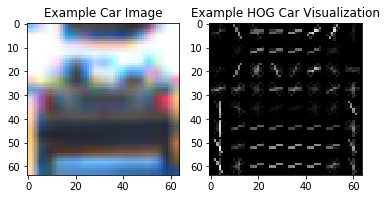

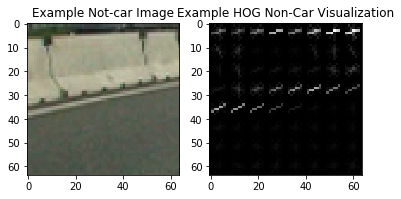

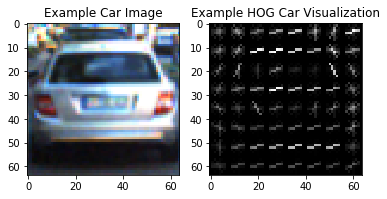

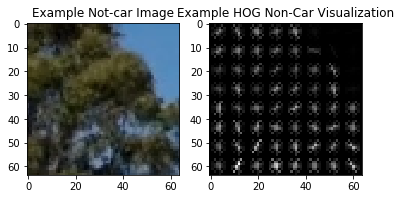

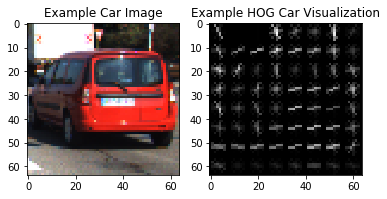

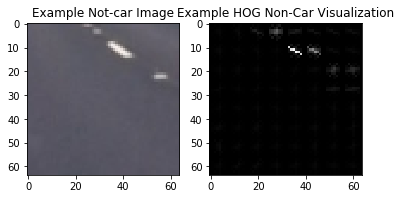

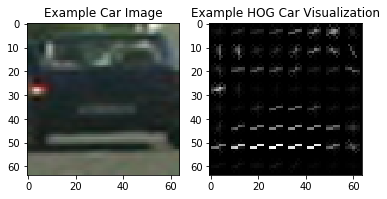

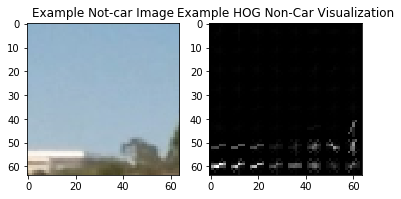

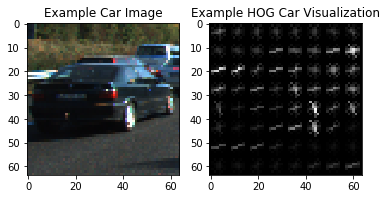

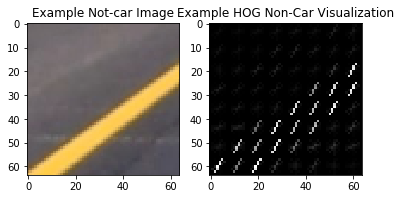

In [9]:
# we are going to choose random car / not-car indices and plot their HOG visualization. 

num_images = 5 


fig = plt.figure()

for i in range(num_images):
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))
    
    # Read in car / not-car images
    car_image = cv2.imread(cars[car_ind],1)
    notcar_image = cv2.imread(notcars[notcar_ind], 1)
            
    car_gray = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)
    notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2GRAY)    
    
    # Define HOG parameters    
    pix_per_cell = 8
    cell_per_block = 2
    orient = 9        
    trans_sqrt = True
    
    # Call our defined function with vis=True to see an image output
    car_features, car_hog_image = get_hog_features(car_gray, orient, 
                                                   pix_per_cell, cell_per_block, 
                                                   vis=True, feature_vec=True, trans_sqrt=trans_sqrt)
    
            
    notcar_features, notcar_hog_image = get_hog_features(notcar_gray, orient, 
                                                         pix_per_cell, cell_per_block, 
                                                         vis=True, feature_vec=True, trans_sqrt=trans_sqrt)
                
    # Plot the car image
    plt.subplot(121)    
    plt.imshow(cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB))
    plt.title('Example Car Image')
    
    # Plot the HOG Car Visualization
    plt.subplot(122)
    plt.imshow(car_hog_image, cmap='gray')
    plt.title('Example HOG Car Visualization')
    
    plt.show()
    
    # Plot the non-car image 
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB))
    plt.title('Example Not-car Image')
        
    # Plot the HOG Car Visualization
    plt.subplot(122)
    plt.imshow(notcar_hog_image, cmap='gray')
    plt.title('Example HOG Non-Car Visualization')
    
    plt.show()
        

In order to detect clearly car and non-car images, we explore different combinations of the following parameters:

* orientations
* pixels_per_cell
* cells_per_block

Also, we have to decide if we apply power law compression to normalize the image. In the cell above we use the following combination of parameters for HOG features: 

* orientations = 9
* pixels_per_cell = 8
* cells_per_block = 2


Moreove, I applied a global image normalisation equalisation that is designed to reduce the influence of illumination effects. In practice we use the square root. From the images above, we can distinguish car from non-cars with the information of their HOG visualization. 

We calculate the size of the vector of HOG features with the following code: 

In [10]:
car_image = cv2.imread(cars[0],1)
            
car_gray = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)

car_features, car_hog_image = get_hog_features(car_gray, orient, 
                                               pix_per_cell, cell_per_block, 
                                               vis=True, feature_vec=True)

print("The size of the vector of HOG features is ", car_features.shape[0])


The size of the vector of HOG features is  1764


Afterward, we are going to use Principal Component Analysis (PCA) in order to reduce the dimension of the input space and improve the model (due to theoretical considerations).

## Storing the data into Pandas DataFrame

We are going to use scikit learn to create a model that identifies vehicles and non-vehicles from the information of the HOG features and color histograms. 

In [11]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [12]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [13]:
# We store the information of the HOG features and color histograms into a Pandas Data Frame. 

hog_cars = []
hog_non_cars = []
color_hist_cars = []
color_hist_non_cars = []


pix_per_cell = 8
cell_per_block = 2
orient = 9        
trans_sqrt = True
hist_bins = 32



for img in cars:    
    car_image = cv2.imread(img,1)
    car_image = car_image.astype(np.float32) / 255
    car_ycrcb = convert_color(car_image, conv='BGR2YCrCb')
        
    ch1 = car_ycrcb[:,:,0]
    ch2 = car_ycrcb[:,:,1]
    ch3 = car_ycrcb[:,:,2]
                            
    car_features1 = get_hog_features(ch1, orient, 
                                    pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True, trans_sqrt=trans_sqrt)  

    car_features2 = get_hog_features(ch2, orient, 
                                    pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True, trans_sqrt=trans_sqrt)  
    

    car_features3 = get_hog_features(ch2, orient, 
                                    pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True, trans_sqrt=trans_sqrt)  
    
    car_features = np.hstack((car_features1, car_features2, car_features3))
        
    
    hog_cars.append(car_features)
    
    hist_features = color_hist(car_image, nbins=hist_bins)
    color_hist_cars.append(hist_features)
    

    
for img in notcars:
    notcar_image = cv2.imread(img,1)
    notcar_image = notcar_image.astype(np.float32) / 255
    notcar_ycrcb = convert_color(notcar_image, conv='BGR2YCrCb')

    
    ch1 = notcar_ycrcb[:,:,0]
    ch2 = notcar_ycrcb[:,:,1]
    ch3 = notcar_ycrcb[:,:,2]
    
        
    
    notcar_features1 = get_hog_features(ch1, orient, 
                                        pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, trans_sqrt=trans_sqrt)

    notcar_features2 = get_hog_features(ch2, orient, 
                                        pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, trans_sqrt=trans_sqrt)
    
    notcar_features3 = get_hog_features(ch3, orient, 
                                        pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, trans_sqrt=trans_sqrt)
    
    notcar_features = np.hstack((notcar_features1, notcar_features2, notcar_features3))    
    
                
    hog_non_cars.append(notcar_features)
    
    hist_features = color_hist(notcar_image, nbins=hist_bins)
    color_hist_non_cars.append(hist_features)


In [14]:
print("Number of car images ",  len(hog_cars))
print("Number of non-car images ", len(hog_non_cars))

Number of car images  8792
Number of non-car images  8968


The data is unbalanced, we will balance the two classes with the following code:

In [15]:
## We are going to balance the data.

diff = len(hog_non_cars) - len(hog_cars)
index_cars =  np.random.choice(len(hog_cars), diff)
hog_cars2 = [hog_cars[i] for i in index_cars] # we use list comprehension. it was useful the following web site:
                                              # https://stackoverflow.com/questions/3179106/python-select-subset-from-list-based-on-index-set
    
color_hist_cars2 = [color_hist_cars[i] for i in index_cars] 
    
hog_cars = hog_cars + hog_cars2 
del hog_cars2 
color_hist_cars = color_hist_cars + color_hist_cars2
del color_hist_cars2


In [16]:
# We create the label variable.  
# 1 = Car
# 0 = Not car

y = ([1] * len(hog_cars)) + ([0] * len(hog_non_cars))

In [17]:
# We concatenate the information of the cars and non-cars
X = hog_cars + hog_non_cars 
color_hist_ = color_hist_cars + color_hist_non_cars


# To save memory 
del hog_cars
del hog_non_cars
del color_hist_cars 
del color_hist_non_cars

In [18]:
import pandas as pd 

In [19]:
size_features = X[0].shape[0] + color_hist_[0].shape[0]

The next cell code was based on the following web sites:

https://stackoverflow.com/questions/13206144/python-and-creating-a-list-wth-a-pattern-x1-x2-x100

https://stackoverflow.com/questions/42952672/build-pandas-data-frame-from-list-of-numpy-arrays

In [20]:
# We are going to create a Pandas DataFrame from the HOG features in the cars and non-cars images.

start = 1
end = len(X) + 1 
names1 = ['%d' % i for i in range(start, end, 1)]

X1 = pd.DataFrame.from_items(zip(names1, X))
X2 = pd.DataFrame.from_items(zip(names1, color_hist_))

X1 = X1.T
X2 = X2.T


X = pd.concat([X1, X2], axis=1)

del X1
del X2
del color_hist_


In [21]:
# We are going to sep up the name of the columns.

start = 1
end = size_features + 1

names2 = ['X%d' % i for i in range(start, end, 1)]

X.columns = names2

We show summary statistics from the second variable of the HOG features. 

In [22]:
X["X2"].describe()

count    17936.000000
mean         0.019645
std          0.023391
min          0.000000
25%          0.005404
50%          0.013536
75%          0.025920
max          0.579754
Name: X2, dtype: float64

In [23]:
# We are going to create a Pandas Series from the y variable (label variable)
y = pd.Series(y) 
# We show summary statistics from the label variable 
y.describe()

count    17936.000000
mean         0.500000
std          0.500014
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
dtype: float64

## Principal Component Analysis 

In [24]:
# This code was taken from 
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


vals = X.ix[:, :].values
X_scaler = StandardScaler().fit(vals)
vals_std = X_scaler.transform(vals)

sklearn_pca = PCA(n_components = 750)
sklearn_pca.fit(vals_std)
vals_pca = sklearn_pca.transform(vals_std)

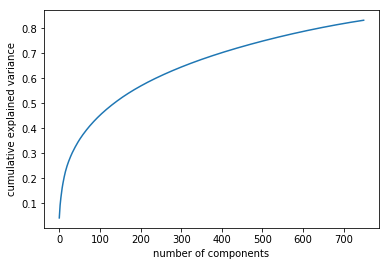

In [25]:
plt.plot(np.cumsum(sklearn_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [26]:
print(sklearn_pca.explained_variance_)
print(sklearn_pca.explained_variance_ratio_)
print(sklearn_pca.explained_variance_ratio_.cumsum())

[ 227.17137912  146.36126528  127.39951574   88.67409185   78.96533383
   71.7030257    65.74705329   62.42154515   55.89630852   48.6300089
   47.58234925   45.20298234   42.097448     40.32308644   38.67065291
   35.33558413   31.87441745   30.70473146   30.24947215   28.96873715
   26.6124054    26.26444116   24.2664689    23.88243887   22.99127334
   22.38073602   21.73835489   21.27991583   20.94972398   20.44864788
   19.68131153   19.51329205   18.46142597   17.86936094   17.80442939
   17.38185866   17.26930398   16.95432652   16.90306765   16.34488086
   16.09393556   15.77610194   15.62725049   15.46507967   15.26925656
   15.0998387    14.82889763   14.6960439    14.2456242    13.86818251
   13.54151475   13.51269427   13.23403868   13.12701339   12.91027816
   12.73421175   12.63999212   12.38321005   12.09360624   11.92444419
   11.79135176   11.76393098   11.680909     11.5104061    11.43922975
   11.34778891   11.23870438   11.16147438   11.09987301   10.90957407
   10.8

Taking 750 components, we have explained the 83% of the variability of the data, 

## XGBoost

XGBoost is a powerful technique based on decision trees. XGBoost is used for classification and regression problems. To install XGBoost in the AWS instance, we have to run the following command: 

pip install xgboost

### Grid search

We are going to use a grid search to determine a good model to classify cars and non-cars images with the information of the HOG features. One of the advantage of using GridSearchCV is multiprocessing, we are going to use 7 cores.  

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [28]:
# shuffle the dataset
vals_pca, y = shuffle(vals_pca, y, random_state=0)

In [29]:
# Split the dataset in two parts
X_train, X_test, y_train, y_test = train_test_split(
    vals_pca, y, test_size=0.2, random_state=0)

In [30]:
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.2, 0.7, 0.9],
    'n_estimators': [10, 20, 50],
    'max_depth': [2, 5, 10]
}


In [31]:
print("# Tuning hyper-parameters")
print()


# Tuning hyper-parameters



We choose the number of K-folds according to the next web site:

https://stats.stackexchange.com/questions/27730/choice-of-k-in-k-fold-cross-validation

K = N / (N*0.30) 

Where N is the size of the data set and K is the number of folds.

In [32]:
X_train.shape[0] /  (X_train.shape[0] * 0.30) 

3.3333333333333335

So we choose K = 4. 

In [33]:
# Instantiate the classifier: gbm
gbm = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Perform grid search: grid
grid = GridSearchCV(param_grid=gbm_param_grid, estimator=gbm, scoring="roc_auc", cv=4, verbose=4, n_jobs=7)

# Fit grid to the data
grid.fit(X_train, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV] colsample_bytree=0.2, n_estimators=10, max_depth=2 ..............
[CV] colsample_bytree=0.2, n_estimators=10, max_depth=2 ..............
[CV] colsample_bytree=0.2, n_estimators=10, max_depth=2 ..............
[CV] colsample_bytree=0.2, n_estimators=10, max_depth=2 ..............
[CV] colsample_bytree=0.2, n_estimators=20, max_depth=2 ..............
[CV] colsample_bytree=0.2, n_estimators=20, max_depth=2 ..............
[CV] colsample_bytree=0.2, n_estimators=20, max_depth=2 ..............
[CV]  colsample_bytree=0.2, n_estimators=10, max_depth=2, score=0.964637099267428, total=   2.1s
[CV] colsample_bytree=0.2, n_estimators=20, max_depth=2 ..............
[CV]  colsample_bytree=0.2, n_estimators=10, max_depth=2, score=0.9722826897966796, total=   2.5s
[CV] colsample_bytree=0.2, n_estimators=50, max_depth=2 ..............
[CV]  colsample_bytree=0.2, n_estimators=10, max_depth=2, score=0.9634547348131568, total=   2.5s
[CV] c

[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    9.7s


[CV]  colsample_bytree=0.2, n_estimators=10, max_depth=5, score=0.9878556550394827, total=   4.4s
[CV]  colsample_bytree=0.2, n_estimators=50, max_depth=2, score=0.9867207610520425, total=   7.5s
[CV] colsample_bytree=0.2, n_estimators=20, max_depth=5 ..............
[CV] colsample_bytree=0.2, n_estimators=20, max_depth=5 ..............
[CV]  colsample_bytree=0.2, n_estimators=50, max_depth=2, score=0.9881474788457696, total=   8.2s
[CV] colsample_bytree=0.2, n_estimators=50, max_depth=5 ..............
[CV]  colsample_bytree=0.2, n_estimators=50, max_depth=2, score=0.9910548090083365, total=   7.4s
[CV] colsample_bytree=0.2, n_estimators=50, max_depth=5 ..............
[CV]  colsample_bytree=0.2, n_estimators=10, max_depth=5, score=0.99145872216001, total=   4.3s
[CV] colsample_bytree=0.2, n_estimators=50, max_depth=5 ..............
[CV]  colsample_bytree=0.2, n_estimators=20, max_depth=5, score=0.9947132014433246, total=   5.5s
[CV] colsample_bytree=0.2, n_estimators=50, max_depth=5 ...

[CV] colsample_bytree=0.7, n_estimators=20, max_depth=10 .............
[CV]  colsample_bytree=0.7, n_estimators=50, max_depth=5, score=0.9983156127588136, total=  50.4s
[CV] colsample_bytree=0.7, n_estimators=20, max_depth=10 .............
[CV]  colsample_bytree=0.7, n_estimators=50, max_depth=5, score=0.998247258642295, total=  53.5s
[CV] colsample_bytree=0.7, n_estimators=50, max_depth=10 .............
[CV]  colsample_bytree=0.7, n_estimators=10, max_depth=10, score=0.996615652606694, total=  23.0s
[CV] colsample_bytree=0.7, n_estimators=50, max_depth=10 .............
[CV]  colsample_bytree=0.7, n_estimators=50, max_depth=5, score=0.9983999004603707, total=  49.2s
[CV] colsample_bytree=0.7, n_estimators=50, max_depth=10 .............
[CV]  colsample_bytree=0.7, n_estimators=20, max_depth=10, score=0.9975418143381211, total=  38.1s
[CV] colsample_bytree=0.7, n_estimators=50, max_depth=10 .............
[CV]  colsample_bytree=0.7, n_estimators=20, max_depth=10, score=0.9971678359376919,

[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:  4.0min


[CV]  colsample_bytree=0.9, n_estimators=10, max_depth=5, score=0.9921852266368214, total=  15.7s
[CV] colsample_bytree=0.9, n_estimators=20, max_depth=5 ..............
[CV]  colsample_bytree=0.9, n_estimators=50, max_depth=2, score=0.9914181286549708, total=  30.0s
[CV] colsample_bytree=0.9, n_estimators=50, max_depth=5 ..............
[CV]  colsample_bytree=0.9, n_estimators=10, max_depth=5, score=0.9916679109120319, total=  11.5s
[CV] colsample_bytree=0.9, n_estimators=50, max_depth=5 ..............
[CV]  colsample_bytree=0.7, n_estimators=50, max_depth=10, score=0.9989812741072539, total= 1.6min
[CV] colsample_bytree=0.9, n_estimators=50, max_depth=5 ..............
[CV]  colsample_bytree=0.9, n_estimators=20, max_depth=5, score=0.9935483209446222, total=  25.7s
[CV] colsample_bytree=0.9, n_estimators=50, max_depth=5 ..............
[CV]  colsample_bytree=0.9, n_estimators=20, max_depth=5, score=0.995692812286265, total=  23.2s
[CV] colsample_bytree=0.9, n_estimators=10, max_depth=10 

[Parallel(n_jobs=7)]: Done 108 out of 108 | elapsed:  7.0min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=7,
       param_grid={'colsample_bytree': [0.2, 0.7, 0.9], 'n_estimators': [10, 20, 50], 'max_depth': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=4)

In [34]:
# Print the best parameters and highest ROC AUC 
print("The Best parameters found: ", grid.best_params_)
print("The Highest Area Under the Receiver Operating Characteristic Curve (ROC AUC) found: ", np.sqrt(np.abs(grid.best_score_)))

The Best parameters found:  {'colsample_bytree': 0.7, 'n_estimators': 50, 'max_depth': 10}
The Highest Area Under the Receiver Operating Characteristic Curve (ROC AUC) found:  0.999242753547


The best model has the following hyperparameters:
* n_estimators = 50
* colsample_bytree = 0.7
* max_depth =  10

Using cross-validation (fold=4) the average of the metric (ROC AUC) on this model is 0.999.

The performance of the model in the test dataset is as follows:

In [35]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=50, colsample_bytree = 0.7, max_depth = 10, seed=123 )
xg_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=1)

In [36]:
y_true, y_pred = y_test, xg_cl.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.98      0.98      1767
          1       0.98      0.97      0.98      1821

avg / total       0.98      0.98      0.98      3588



From the above summary on the test dataset, we concluded that the model works very well. 

Finally, the model is trained on the whole dataset.

In [37]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=50, colsample_bytree = 0.7, max_depth = 10, seed=123 )
xg_cl.fit(vals_pca, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=1)

## Hog Sub-sampling windows search 

We modify the function find_cars (provided by Udacity videos) to take account of the previous steps. 

In [38]:
# Define a single function that can extract features using hog sub-sampling and make predictions.
# More, we return the information of the boxes.
def find_cars(img, ystart, ystop, scale, orient, pix_per_cell, cell_per_block, hist_bins):
        
    bbox_list = []
    
    draw_img = np.copy(img)
        
    img_tosearch = img[ystart:ystop,:,:]    
    img_tosearch = img_tosearch.astype(np.float32) / 255
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')
        
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False, trans_sqrt=True)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False, trans_sqrt=True)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False, trans_sqrt=True)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()                         
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # We preprocess the hog features and color histograms. 
            hog_feat1 = hog_feat1.reshape(-1, 1)
            hog_feat1 = hog_feat1.T 
            
            hog_feat2 = hog_feat2.reshape(-1, 1)
            hog_feat2 = hog_feat2.T 

            hog_feat3 = hog_feat3.reshape(-1, 1)
            hog_feat3 = hog_feat3.T 
            
            hog_feat = np.hstack((hog_feat1, hog_feat2, hog_feat3))    
                    
            
            subimg = cv2.resize(img_tosearch[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window], (64,64))
            
            hist_features = color_hist(subimg, nbins=hist_bins)            
            hist_features = hist_features.reshape(-1, 1)            
            hist_features = hist_features.T 
                        
            names3 = [1]
            X1 = pd.DataFrame.from_items(zip(names3, hog_feat))
            X1 = X1.T
            
            X2 = pd.DataFrame.from_items(zip(names3, hist_features))
            X2 = X2.T
            
            X = pd.concat([X1, X2], axis=1)
            
            X.columns = names2 
            X = X.ix[:, :].values
            
            # We generate the prediction.
            
            test_features = X_scaler.transform(X)
            test_features = sklearn_pca.transform(test_features)
            test_prediction = xg_cl.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)                 
                bbox_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))                 
                
    return draw_img, bbox_list

We apply the previous function to the test images.

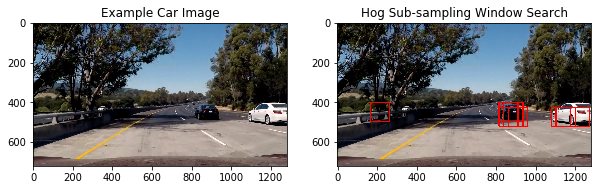

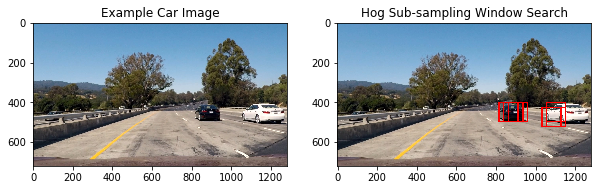

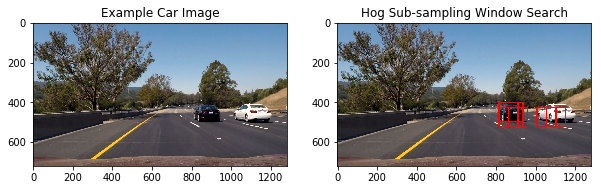

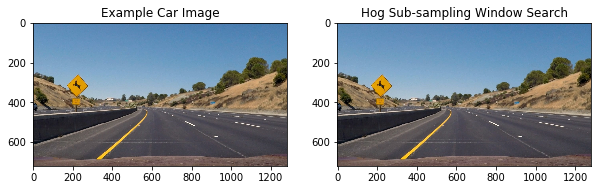

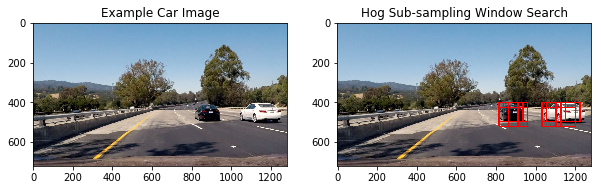

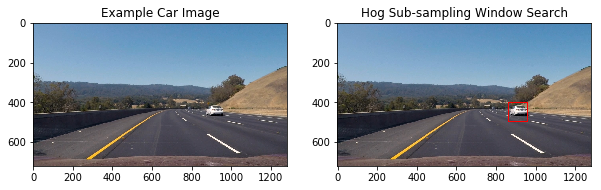

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 15 # figure with width 5 inches, and its height 10 inches. 


images = glob.glob('test_images/*.jpg')



for file_image in images:
    img = cv2.imread(file_image,1)
    
    ystart = 400
    ystop = 656
    scale = 1.5

    pix_per_cell = 8
    cell_per_block = 2
    orient = 9 
    hist_bins = 32

    
    out_img, bbox_list = find_cars(img, ystart, ystop, scale, orient, pix_per_cell, cell_per_block, hist_bins)
        
    
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))     
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)) 
    plt.title('Hog Sub-sampling Window Search')
    plt.show()
    
    


The function works well but there are some false positives and overlapping detections, we are going to fix this issue with the following codes.

## Using heatmap to remove false positives 

From the images above it seems that XGBoost has generated some false positives. We are going to use the following functions provided by Udacity in order to remove false positives using heatmaps and a threshold of 1.

In [40]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


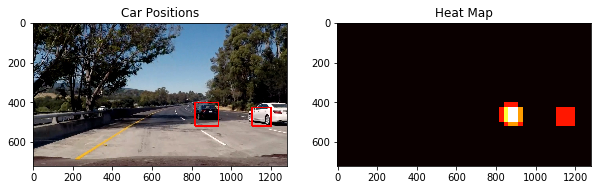

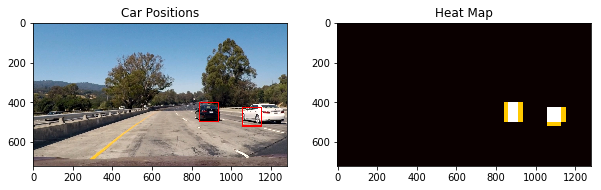

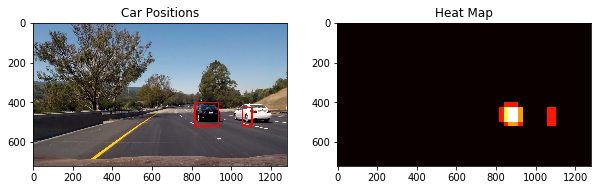

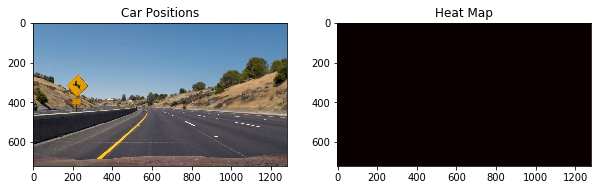

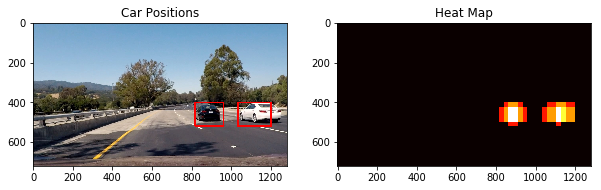

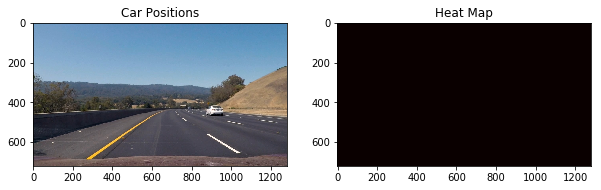

In [41]:
images = glob.glob('test_images/*.jpg')



for file_image in images:
    img = cv2.imread(file_image,1)
    
    ystart = 400
    ystop = 656
    scale = 1.5

    pix_per_cell = 8
    cell_per_block = 2
    orient = 9 
    hist_bins = 32
    
    out_img, bbox_list = find_cars(img, ystart, ystop, scale, orient, pix_per_cell, cell_per_block, hist_bins)

    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    plt.subplot(121)
    plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.show()

It works well, next we are going to create a function to process the images in the video.

## Making the pipeline and generating the video.

In [42]:
def process_image(img):  
    
    ystart = 400
    ystop = 656
    scale = 1.5

    pix_per_cell = 8
    cell_per_block = 2
    orient = 9 
    hist_bins = 32

    
    out_img, bbox_list = find_cars(img, ystart, ystop, scale, orient, pix_per_cell, cell_per_block, hist_bins)
    
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img
        

In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


video_input = './project_video.mp4'
video_output = './output_videos/outputVideo.mp4'

project_video = VideoFileClip(video_input)

treated_video = project_video.fl_image(process_image)
%time treated_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/outputVideo.mp4
[MoviePy] Writing video ./output_videos/outputVideo.mp4


100%|█████████▉| 1260/1261 [1:52:26<00:05,  5.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/outputVideo.mp4 

CPU times: user 3h 44min 52s, sys: 10h 38min 52s, total: 14h 23min 44s
Wall time: 1h 52min 27s
